<a href="https://colab.research.google.com/github/haooooooqi/visualization/blob/main/video_mae_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [3]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if True:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !pip3 install opencv3
    !pip3 install simplejson
    !pip3 install matplotlib
    !pip3 install iopath
    !pip install common
    !pip install fvcore
    !pip install av
    !rm -rf visualization mae
    !git clone https://github.com/haooooooqi/visualization.git
    !mv visualization mae
    sys.path.append('./mae')
    !rm -rf slowfast SlowFast
    !git clone https://github.com/facebookresearch/SlowFast.git
    !mv SlowFast slowfast
    sys.path.append('./slowfast')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
ERROR: Could not find a version that satisfies the requirement opencv3 (from versions: none)
ERROR: No matching distribution found for opencv3
Cloning into 'visualization'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 83 (delta 24), reused 51 (delta 5), pack-reused 0
Unpacking objects: 100% (83/83), done.
Cloning into 'SlowFast'...
remote: Enumerating objects: 1773, done.
remote: Counting objects: 100% (1133/1133), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 1773 (delta 1003), reused 927 (delta 927), pack-reused 640
Receiving objects: 100% (1773/1773), 30.47 MiB | 29.71 MiB/s, done.
Resolving deltas: 100% (1261/1261), done.


### Define utils

In [4]:
from slowfast.datasets.decoder import pyav_decode, temporal_sampling
from mae.util.decoder.utils import tensor_normalize, spatial_sampling
import av


MEAN = (0.45, 0.45, 0.45)
STD = (0.225, 0.225, 0.225)
DEMO_PATH = "mae/demo/qZ_lFjCiR1c_000104_000114.avi"

def prepare_video(path):
    video_container = av.open(path)
    frames, _, _ = pyav_decode(
        video_container,
        4,
        16,
        5,
        num_clips_uniform=10,
        target_fps=30,
        use_offset=False,
    )
    frames = temporal_sampling(frames, 0, 64, 16)
    frames = tensor_normalize(
        frames, 
        torch.tensor(MEAN), 
        torch.tensor(STD),
    ).permute(3, 0, 1, 2)
    frames = spatial_sampling(
        frames,
        spatial_idx=1,
        min_scale=256,
        max_scale=256,
        crop_size=224,
        random_horizontal_flip=False,
        inverse_uniform_sampling=False,
        aspect_ratio=None,
        scale=None,
        motion_shift=False,
    )
    return frames


def plot_input(tensor):
    tensor = tensor.float()
    f, ax = plt.subplots(nrows=tensor.shape[0], ncols=tensor.shape[1], figsize=(50, 20))

    tensor = tensor * torch.tensor(STD).view(3, 1, 1)
    tensor = tensor + torch.tensor(MEAN).view(3, 1, 1)
    tensor = torch.clip(tensor * 255, 0, 255).int()

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax[i][j].axis("off")
            ax[i][j].imshow(tensor[i][j].permute(1, 2, 0))
    plt.show()

Please update your PyTorchVideo to latest master


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  "The _transforms_video module is deprecated. Please use the transforms module instead."


In [5]:
vid = prepare_video(DEMO_PATH)

In [6]:
from mae.models_mae import mae_vit_large_patch16
model = mae_vit_large_patch16(decoder_embed_dim=512, decoder_depth=4, mask_type="st", t_patch_size=2)

img_size (224, 224) patch_size (16, 16) frames 16 t_patch_size 2
==== num_patches 1568
model initialized


In [7]:
!wget 'https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth' -O checkpoint.pth
# !wget 'https://dl.fbaipublicfiles.com/video-mae-200x4-nonorm.pth' -O checkpoint.pth 

--2022-04-25 01:06:45--  https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823763371 (3.6G) [binary/octet-stream]
Saving to: ‘checkpoint.pth’

checkpoint.pth      100%[===================>]   3.56G  30.5MB/s    in 86s     

2022-04-25 01:08:11 (42.4 MB/s) - ‘checkpoint.pth’ saved [3823763371/3823763371]



In [8]:
checkpoint = torch.load("./checkpoint.pth", map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


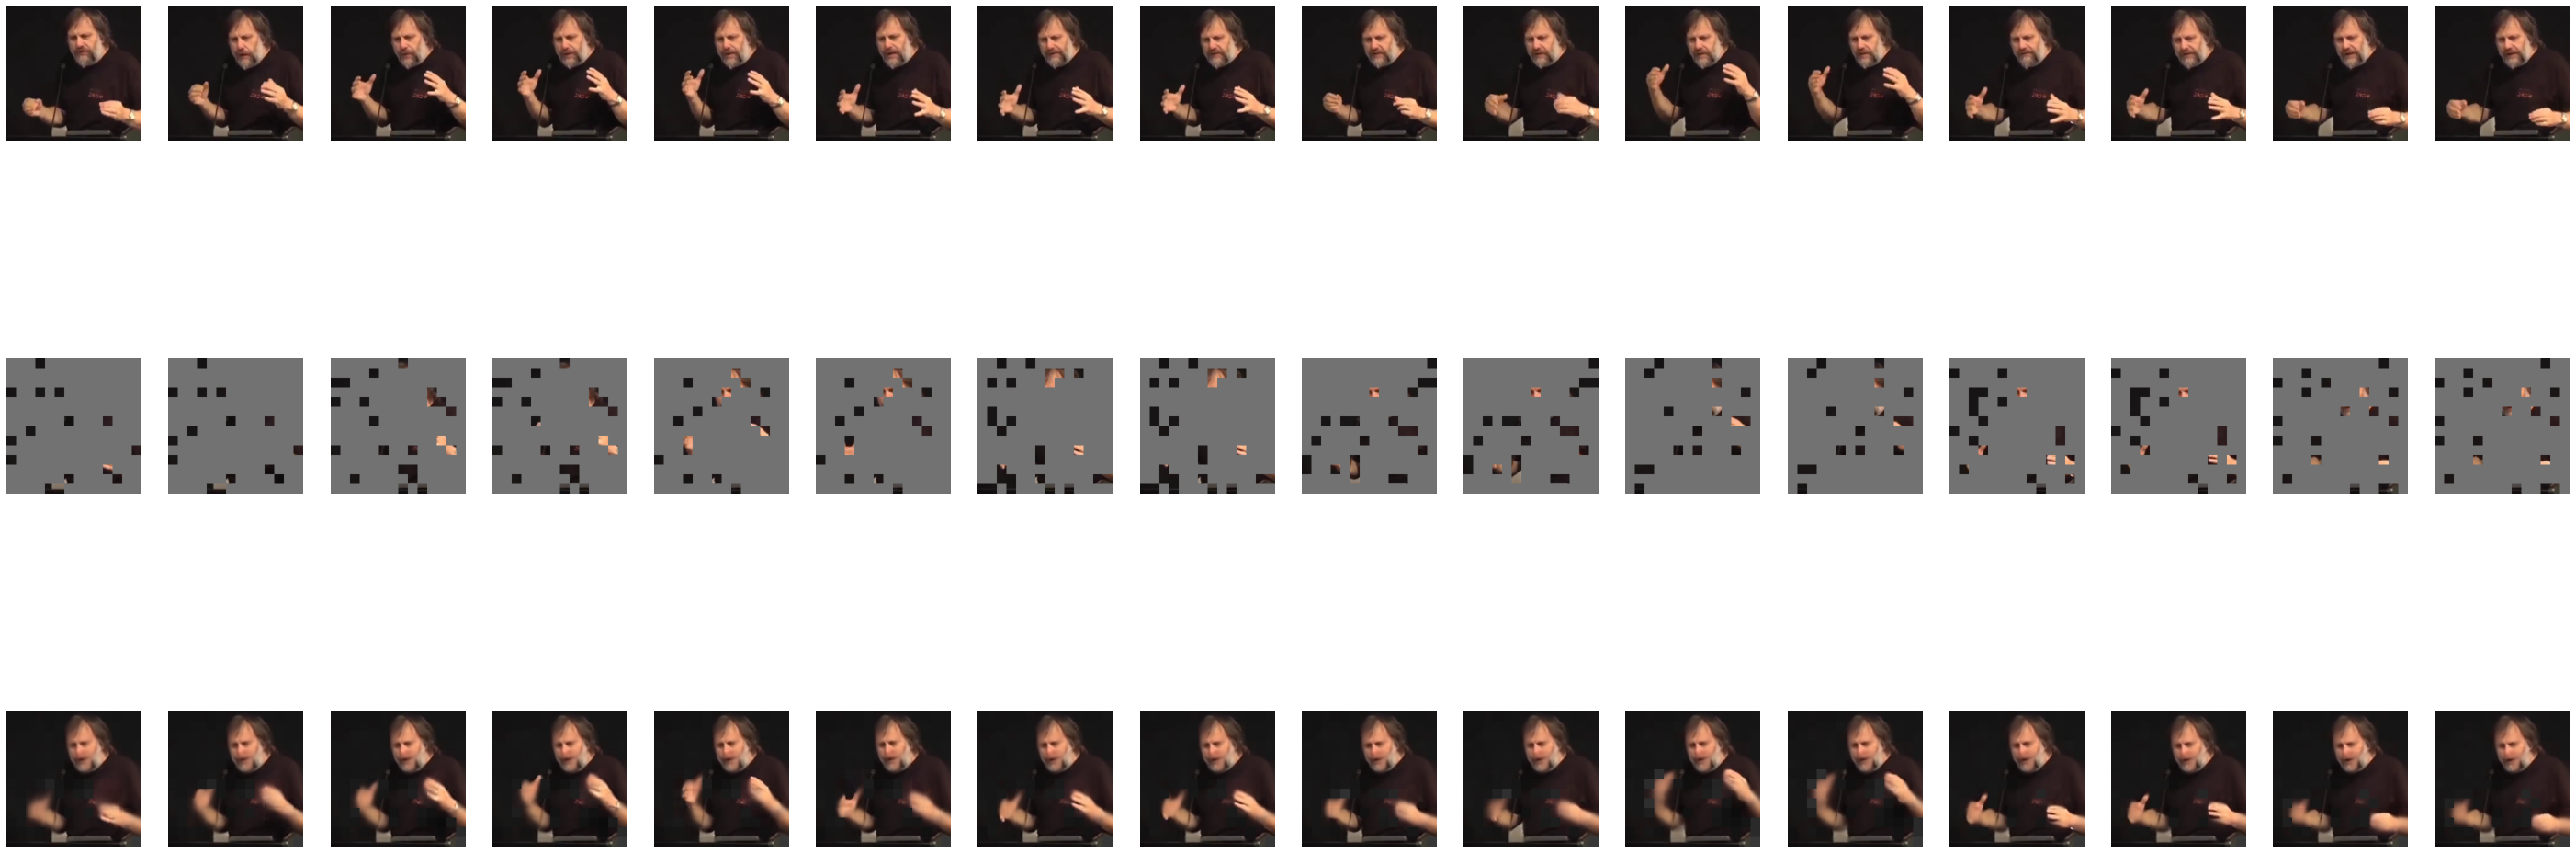

In [9]:
_, _, _, vis = model(vid.unsqueeze(0), 1, mask_ratio=0.9, visualize=True)
plot_input(vis[0].permute(0, 2, 1, 3, 4))